In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('classic')

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
df = pd.read_csv("https://www.ndbc.noaa.gov/data/realtime2/46268.txt",delim_whitespace=True)
df.info()

df.drop(index=df.index[0],
        axis=0,
        inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2154 entries, 0 to 2153
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   #YY     2154 non-null   object
 1   MM      2154 non-null   object
 2   DD      2154 non-null   object
 3   hh      2154 non-null   object
 4   mm      2154 non-null   object
 5   WDIR    2154 non-null   object
 6   WSPD    2154 non-null   object
 7   GST     2154 non-null   object
 8   WVHT    2154 non-null   object
 9   DPD     2154 non-null   object
 10  APD     2154 non-null   object
 11  MWD     2154 non-null   object
 12  PRES    2154 non-null   object
 13  ATMP    2154 non-null   object
 14  WTMP    2154 non-null   object
 15  DEWP    2154 non-null   object
 16  VIS     2154 non-null   object
 17  PTDY    2154 non-null   object
 18  TIDE    2154 non-null   object
dtypes: object(19)
memory usage: 319.9+ KB


In [3]:
df['WVHT'] = df['WVHT'].astype(float)


In [4]:
df = df.reindex(index=df.index[::-1])

In [5]:
df

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
2153,2022,07,30,00,00,MM,MM,MM,0.5,13,4.7,192,MM,21.3,21.3,MM,MM,MM,MM
2152,2022,07,30,00,30,MM,MM,MM,0.6,13,4.8,200,MM,21.5,21.3,MM,MM,MM,MM
2151,2022,07,30,01,00,MM,MM,MM,0.6,13,4.9,193,MM,21.6,21.2,MM,MM,MM,MM
2150,2022,07,30,01,30,MM,MM,MM,0.6,13,4.5,198,MM,21.5,21.0,MM,MM,MM,MM
2149,2022,07,30,02,00,MM,MM,MM,0.6,13,4.2,199,MM,21.2,20.9,MM,MM,MM,MM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2022,09,12,22,00,MM,MM,MM,0.7,13,5.6,206,MM,23.2,22.8,MM,MM,MM,MM
4,2022,09,12,22,30,MM,MM,MM,0.8,13,5.2,202,MM,23.2,22.8,MM,MM,MM,MM
3,2022,09,12,23,00,MM,MM,MM,0.8,13,5.6,205,MM,23.2,22.7,MM,MM,MM,MM
2,2022,09,12,23,30,MM,MM,MM,0.8,13,5.2,199,MM,23.2,22.6,MM,MM,MM,MM


In [6]:
df.rename(columns={"#YY": "year",
                   "MM": "month",
                   "DD": "day",
                   "hh": "hour",
                   "mm": "minute"})



,year,month,day,hour,minute,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
2153,2022,07,30,00,00,MM,MM,MM,0.5,13,4.7,192,MM,21.3,21.3,MM,MM,MM,MM
2152,2022,07,30,00,30,MM,MM,MM,0.6,13,4.8,200,MM,21.5,21.3,MM,MM,MM,MM
2151,2022,07,30,01,00,MM,MM,MM,0.6,13,4.9,193,MM,21.6,21.2,MM,MM,MM,MM
2150,2022,07,30,01,30,MM,MM,MM,0.6,13,4.5,198,MM,21.5,21.0,MM,MM,MM,MM
2149,2022,07,30,02,00,MM,MM,MM,0.6,13,4.2,199,MM,21.2,20.9,MM,MM,MM,MM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2022,09,12,22,00,MM,MM,MM,0.7,13,5.6,206,MM,23.2,22.8,MM,MM,MM,MM
4,2022,09,12,22,30,MM,MM,MM,0.8,13,5.2,202,MM,23.2,22.8,MM,MM,MM,MM
3,2022,09,12,23,00,MM,MM,MM,0.8,13,5.6,205,MM,23.2,22.7,MM,MM,MM,MM
2,2022,09,12,23,30,MM,MM,MM,0.8,13,5.2,199,MM,23.2,22.6,MM,MM,MM,MM


In [12]:
train_y = torch.tensor(df['WVHT'].values.astype(np.float32)).cuda()
train_x = torch.linspace(0,1,train_y.shape[0]).cuda()

In [22]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True,
                          generator = torch.Generator(device='cuda'))

In [23]:
from gpytorch.kernels import RBFKernel, CosineKernel, ScaleKernel, PeriodicKernel
from custom_kernel import MinKernel, AR2Kernel

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, kernel = None):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [24]:
kernel = (
        ScaleKernel(AR2Kernel()) +
        ScaleKernel(MinKernel()) +
        ScaleKernel(RBFKernel()) +
        ScaleKernel(RBFKernel()*PeriodicKernel())
        )



inducing_points = train_x[:500]
model = GPModel(inducing_points=inducing_points, kernel = kernel)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [43]:
num_epochs = 150

model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)
optimizer.param_groups[0]['capturable'] = True
optimizer.param_groups[1]['capturable'] = True

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

epochs_iter = range(num_epochs)
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = train_loader
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        #minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()
        print(loss)




tensor(0.8819, grad_fn=<NegBackward0>)
tensor(1.0320, grad_fn=<NegBackward0>)
tensor(0.8589, grad_fn=<NegBackward0>)
tensor(0.8460, grad_fn=<NegBackward0>)
tensor(0.8589, grad_fn=<NegBackward0>)
tensor(0.8383, grad_fn=<NegBackward0>)
tensor(0.8274, grad_fn=<NegBackward0>)
tensor(0.8217, grad_fn=<NegBackward0>)
tensor(0.8160, grad_fn=<NegBackward0>)
tensor(0.8112, grad_fn=<NegBackward0>)
tensor(0.8043, grad_fn=<NegBackward0>)
tensor(0.7968, grad_fn=<NegBackward0>)
tensor(0.7874, grad_fn=<NegBackward0>)
tensor(0.7772, grad_fn=<NegBackward0>)
tensor(0.7690, grad_fn=<NegBackward0>)
tensor(0.7623, grad_fn=<NegBackward0>)
tensor(0.7589, grad_fn=<NegBackward0>)
tensor(0.7557, grad_fn=<NegBackward0>)
tensor(0.7530, grad_fn=<NegBackward0>)
tensor(0.7502, grad_fn=<NegBackward0>)
tensor(0.7464, grad_fn=<NegBackward0>)
tensor(0.7411, grad_fn=<NegBackward0>)
tensor(0.7353, grad_fn=<NegBackward0>)
tensor(0.7300, grad_fn=<NegBackward0>)
tensor(0.7250, grad_fn=<NegBackward0>)
tensor(0.7211, grad_fn=<N

In [55]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0,1.2,1000)
    observed_pred = likelihood(model(test_x))

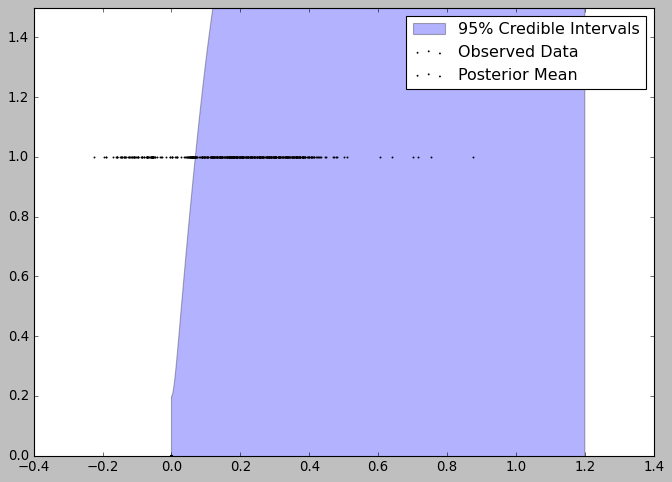

In [57]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(10, 7))

# Get upper and lower confidence bounds
lower, upper = observed_pred.confidence_region()
# Shade between the lower and upper confidence bounds
ax.fill_between(test_x.detach().cpu().numpy(),
                lower.detach().cpu().numpy(),
                upper.detach().cpu().numpy(), alpha=0.3)
# Plot training data as black stars
ax.scatter(train_x.detach().cpu().numpy(), train_y.detach().cpu().numpy(), s=0.5)
ax.scatter(model.variational_strategy.inducing_points[:,0].detach().cpu().numpy(),
           np.zeros(500)+1, s=0.5)
# Plot predictive means as blue line
ax.plot(test_x.detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'blue')

ax.set_ylim([0, 1.5])
#ax.patch.set_facecolor('green')
#ax.patch.set_alpha(.1)
ax.legend(["95% Credible Intervals", "Observed Data", "Posterior Mean"])

tensor([ 1.9243e-01, -1.5992e-01, -1.1568e-01, -7.5339e-02,  1.1829e-01,
        -4.7048e-02,  7.0906e-02,  1.4046e-02, -1.9027e-01, -3.3771e-03,
         9.9182e-02,  1.2264e-01,  5.9763e-02,  2.7936e-04, -4.8463e-03,
         8.8618e-02,  8.9812e-02, -1.4530e-02,  1.6060e-01,  9.7823e-02,
        -6.0411e-02, -2.6977e-02, -3.3297e-02, -2.2551e-01,  6.4137e-02,
         6.3387e-02,  5.5679e-02,  1.5591e-02,  1.8257e-01,  1.4202e-01,
         6.7689e-02, -4.3002e-02,  5.4911e-02,  5.5310e-02,  4.2222e-02,
         1.9161e-01,  5.7639e-02, -4.8570e-02,  6.2235e-02,  6.0951e-02,
        -5.2474e-02,  6.0814e-02,  1.4742e-01,  1.3304e-01, -5.5023e-02,
         9.2638e-03,  2.1723e-01,  4.7511e-02,  1.4666e-01,  6.1337e-02,
         1.8001e-01,  1.6372e-01,  3.8723e-01, -5.7134e-02,  1.7572e-01,
         6.5618e-02,  2.0881e-01,  1.4600e-02,  1.4269e-01,  4.6884e-02,
         1.8514e-01, -5.7084e-02, -5.8080e-02,  3.5297e-02, -5.8410e-02,
         1.6004e-01, -2.9007e-02,  2.7626e-02,  1.5